<a href="https://colab.research.google.com/github/horaja/PointCloudAutoEncoder/blob/main/PointCloud_Autoencoder_Official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
The following codeblock is for library imports.
```



In [3]:
import Dataloaders
import utils
import model

import torch
import time
import matplotlib.pyplot as plt

```
Next, we must configure necessary parameters:
 - batch size
 - name of output folder to save results
 - save results enable/disable flag
 - GPU acceleration flag
 - dimension of compressed representation
```

In [4]:
batch_size = 32
output_folder = "output/"
save_results = False
use_GPU = True
latent_size = 128

if(save_results):
    utils.clear_folder(output_folder)

```
Next, we must load in our data properly

We must also condense thousands of pointcloud snapshots into one file.

Factors to influence:
 - # of snapshots
 - # of points per snapshot
 - area to extract points for each snapshot (ranges)
```

In [6]:
input_folder = "/content/input_data"

combined_data = Dataloaders.CondensePointClouds(input_folder, 1024)
pc_array = combined_data
print(pc_array.shape) # for testing purposes

train_loader, test_loader = Dataloaders.GetDataLoaders(npArray=pc_array, batch_size=batch_size)
print(f"Train dataset size: {len(train_loader.dataset)}") # for testing purposes
print(f"Test dataset size: {len(test_loader.dataset)}") # for testing purposes
print(f"Batch size: {batch_size}") # for testing purposes

point_size = len(train_loader.dataset[0])

(501, 1024, 3)
Train dataset size: 350
Test dataset size: 151
Batch size: 32


```
Model Setup
```

In [7]:
net = model.PointCloudAE(point_size,latent_size)

if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

```
Import and initialize loss (chamfer distance)
Define an optimizer
```

In [8]:
!pip install chamferdist
from chamferdist import ChamferDistance
chamfer_distance = ChamferDistance()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

```
Next, we must define training and testing functions
```

In [9]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data.permute(0,2,1))
        loss = chamfer_distance(data, output)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/i

In [10]:
def test_batch(data):
    with torch.no_grad():
        output = net(data.permute(0,2,1))
        loss = chamfer_distance(data, output)

    return loss.item(), output.cpu()

In [11]:
def test_epoch():
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    if i != 0:
      return epoch_loss/i
    return epoch_loss

```
Training Loop

Be sure to edit the number of epochs!
```

epoch 0 train loss : 99.6791275024414 test loss : 113.25953102111816 epoch time : 6.330276250839233



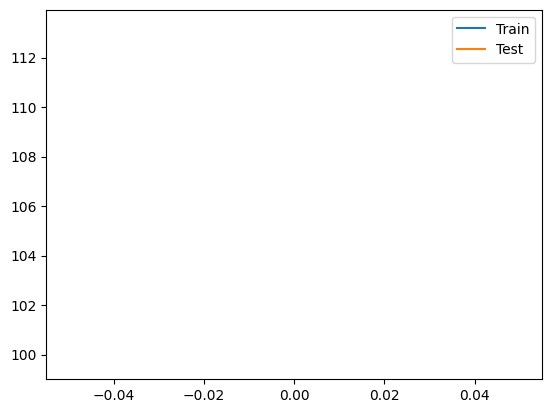

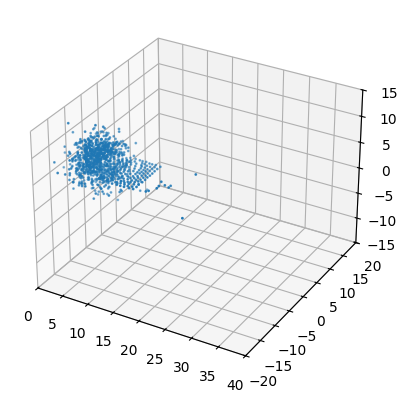

epoch 1 train loss : 99.09362106323242 test loss : 112.26342391967773 epoch time : 5.489345073699951



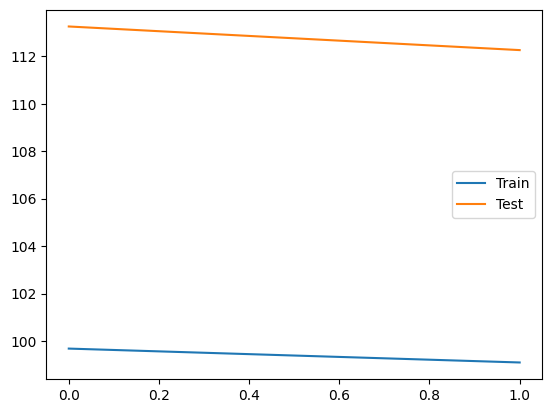

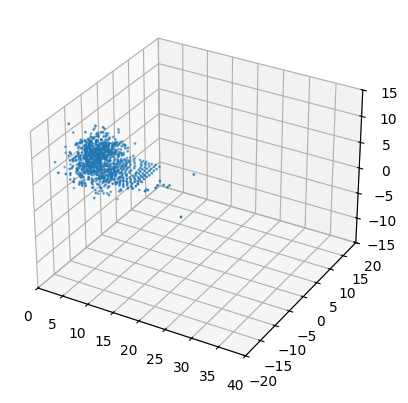

epoch 2 train loss : 98.23949279785157 test loss : 110.86007308959961 epoch time : 6.292607069015503



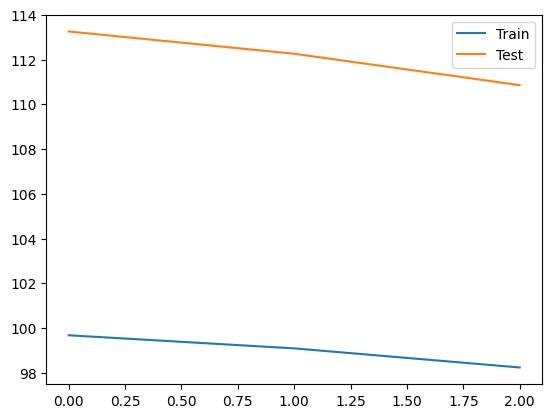

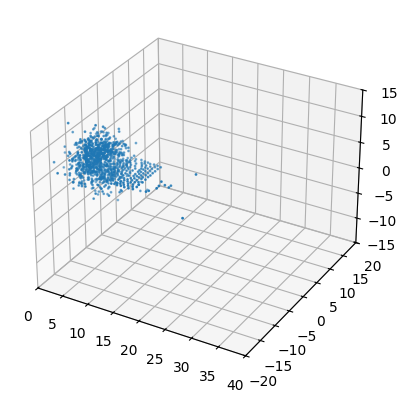

epoch 3 train loss : 97.70120544433594 test loss : 110.93626022338867 epoch time : 5.600918531417847



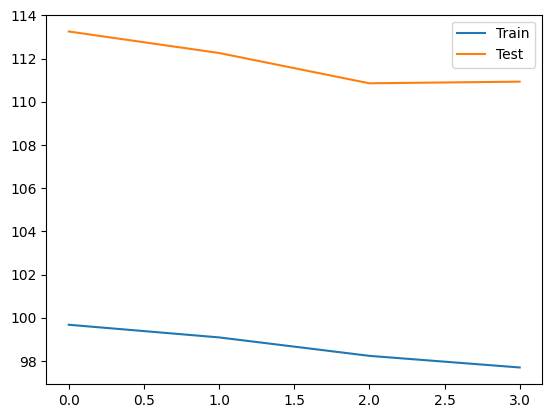

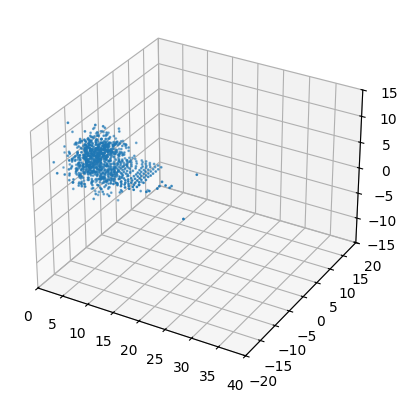

epoch 4 train loss : 97.42568588256836 test loss : 110.63536262512207 epoch time : 6.391427516937256



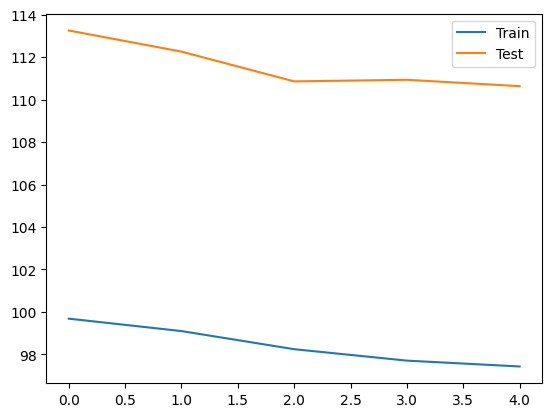

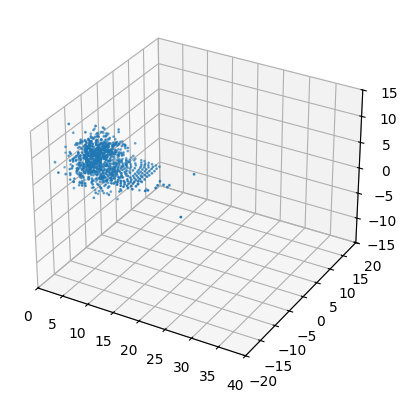

epoch 5 train loss : 97.353271484375 test loss : 111.1324291229248 epoch time : 5.6422035694122314



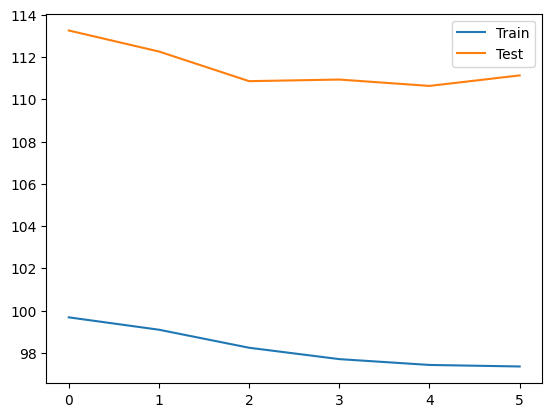

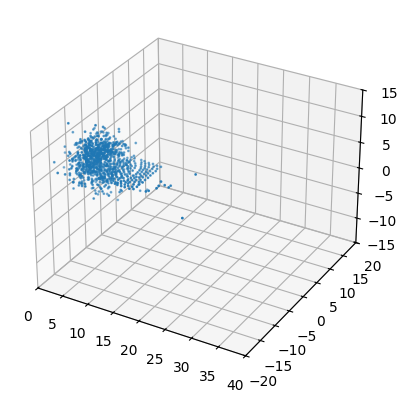

epoch 6 train loss : 97.0159896850586 test loss : 109.83764839172363 epoch time : 5.992149829864502



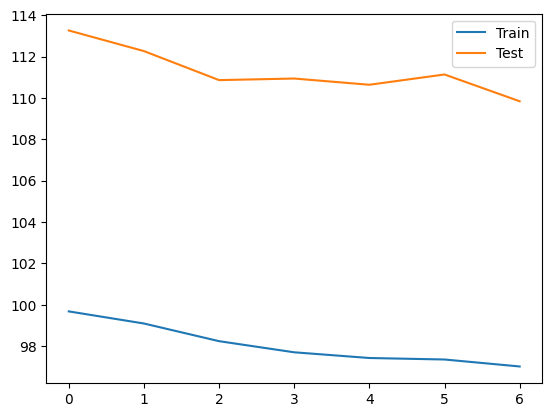

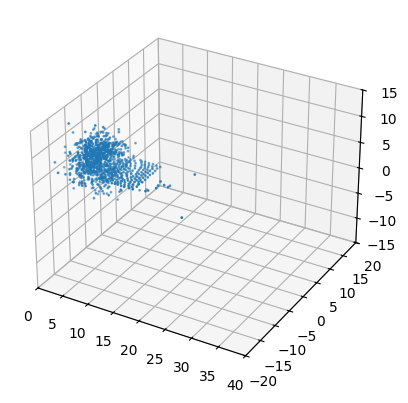

epoch 7 train loss : 96.24647903442383 test loss : 110.25709342956543 epoch time : 6.270101308822632



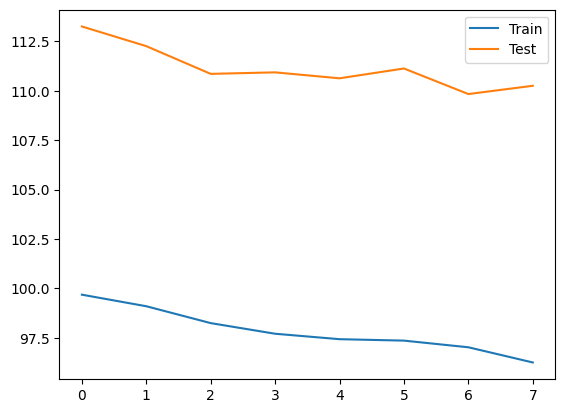

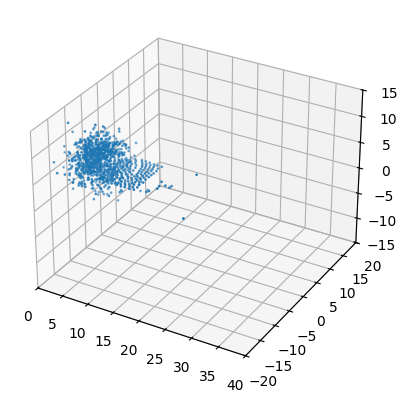

epoch 8 train loss : 95.97740020751954 test loss : 108.83548545837402 epoch time : 5.588249921798706



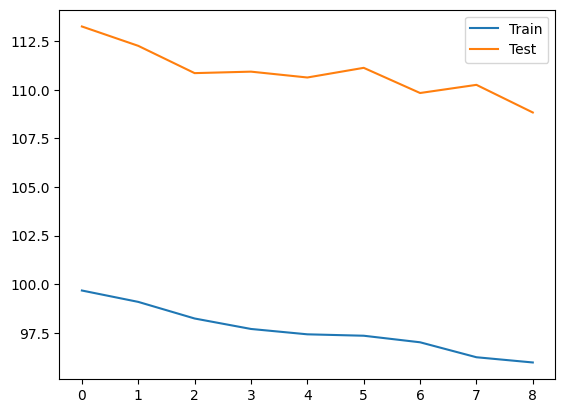

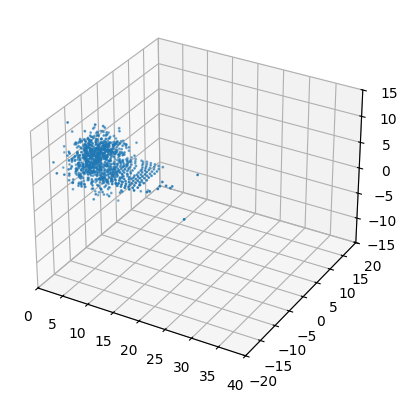

epoch 9 train loss : 95.69991607666016 test loss : 108.62732124328613 epoch time : 6.450763940811157



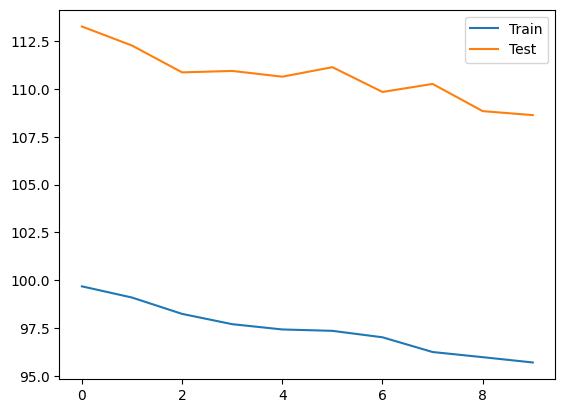

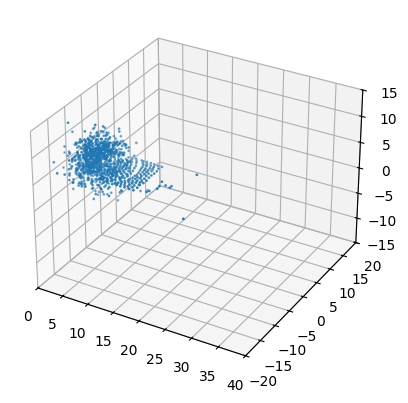

In [16]:
train_loss_list = []
test_loss_list = []

for i in range(1) :

    startTime = time.time()
    train_loss = train_epoch()
    train_loss_list.append(train_loss)

    test_loss = test_epoch()
    test_loss_list.append(test_loss)

    epoch_time = time.time() - startTime

    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"

    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if (save_results):
        with open(output_folder + "prints.txt","a") as file:
            file.write(writeString)

        plt.savefig(output_folder + "loss.png")
        plt.close()

        # FIX: save all these to output folder, not just show them.
        if(i%50==0):
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            utils.visualise_3(test_output[i], output_file= (output_folder  + "epoch_" + str(i)))

    else:
        print(writeString)
        test_samples = next(iter(test_loader))
        loss , test_output = test_batch(test_samples)
        index = i % len(test_output)
        utils.visualise_3(test_output[index])
        plt.show()
